
### This script runs hyperparam selection for one-hop traversal on graph using natural language. Before running this notebook, make sure to run: codes/py_scripts/rag_based_text_generation/GPT/two_hop_traversal_hyperparameter_tuning.py 
### This will save the csv files that are used in this notebook


In [1]:
import pandas as pd
import numpy as np
import json
import ast
from tqdm import tqdm
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem


In [2]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection    
    if union == 0:
        return 0.0
    else:
        jaccard_similarity = intersection / union
        return jaccard_similarity
    
def extract_answer(text):
    pattern = r'{[^{}]*}'
    match = re.search(pattern, text)
    if match:
        return match.group()
    else:
        return None
    
def extract_by_splitting(text):
    compound_list = text.split(':')[1].split("Diseases")[0].split("], ")[0]+"]"
    disease_list = text.split(':')[-1].split("}")[0]
    resp = {}
    resp["Compounds"] = ast.literal_eval(compound_list)
    resp["Diseases"] = ast.literal_eval(disease_list)
    return resp
    

In [3]:
PARENT_PATH = "../../../data/analysis_results/"


FILES = [
    "gpt_4_node_retrieval_rag_based_two_hop_questions_parameter_tuning_round_1.csv",
    "gpt_4_node_retrieval_rag_based_two_hop_questions_parameter_tuning_round_2.csv",
    "gpt_4_node_retrieval_rag_based_two_hop_questions_parameter_tuning_round_3.csv",
    "gpt_4_node_retrieval_rag_based_two_hop_questions_parameter_tuning_round_4.csv",
    "gpt_4_node_retrieval_rag_based_two_hop_questions_parameter_tuning_round_5.csv"
]


In [5]:
df = pd.read_csv(os.path.join(PARENT_PATH, FILES[0]))
df

,disease_1,disease_2,central_nodes_groundTruth,text,llm_answer,context_volume
0,optic atrophy,psammomatous meningioma,"['arachnoid mater', 'internal carotid artery',...",What are the Anatomy that are commonly associa...,"{""Nodes"":[""optic tract""]}",10
1,tongue disease,Crouzon syndrome,"['mandible', 'foramen magnum', 'lower jaw regi...",What are the Anatomy that are commonly associa...,"{""Nodes"": [""Anatomy tongue""]}",10
2,Dandy-Walker syndrome,optic atrophy,"['skull', 'arachnoid mater']",What are the Anatomy that are commonly associa...,"{""Nodes"":[""brain"", ""eye""]}",10
3,goiter,Human papillomavirus infectious disease,"['Voice Disorders', 'Respiratory Sounds']",What are the Symptoms that are commonly associ...,"{""Nodes"":[]}",10
4,insulinoma,congenital diaphragmatic hernia,['gastric juice'],What are the Anatomy that are commonly associa...,"{""Nodes"":[]}",10
...,...,...,...,...,...,...
85,refractive error,visual impairment and progressive phthisis bulbi,"['ciliary body', 'corneal epithelium', 'anteri...",What are the Anatomy that are commonly associa...,"{""Nodes"":[""optic tract"", ""retina"", ""eye""]}",10
86,septooptic dysplasia,disorder of sexual development,['Intellectual Disability'],What are the Symptoms that are commonly associ...,"{""Nodes"": [""Anterior pituitary dysgenesis"", ""P...",10
87,hereditary night blindness,disease of anatomical entity,"['CABP4', 'NYX', 'GNB3', 'TRPM1', 'RHO', 'GRM6...",What are the Genes that are commonly associate...,"{""Nodes"":[]}",10
88,Pelizaeus-Merzbacher disease,primary progressive multiple sclerosis,"['brain', 'central nervous system', 'entire my...",What are the Anatomy that are commonly associa...,"{""Nodes"":[""central nervous system"", ""brain""]}",10


In [8]:
llm_performance_list = []
for file in tqdm(FILES):
    df = pd.read_csv(os.path.join(PARENT_PATH, file))
    df.dropna(subset=["llm_answer"], inplace=True)
    llm_performance_list_across_questions = []
    for index, row in df.iterrows():
        ground_truth = ast.literal_eval(row["central_nodes_groundTruth"])
        try:
            llm_answer = json.loads(row["llm_answer"])
        except:
            try:
                llm_answer = ast.literal_eval(row["llm_answer"].split("Nodes:")[-1])
            except:
                llm_answer = []
        if not isinstance(llm_answer, list):
            llm_result = llm_answer["Nodes"]
        else:
            llm_result = llm_answer
        llm_performance_list_across_questions.append(jaccard_similarity(ground_truth, llm_result))
    llm_performance_list.append((np.mean(llm_performance_list_across_questions), np.std(llm_performance_list_across_questions), sem(llm_performance_list_across_questions), row["context_volume"]))


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 46.59it/s]


In [9]:
hyperparam_perf = pd.DataFrame(llm_performance_list, columns=["performance_mean", "performance_std", "performance_sem", "context_volume"])



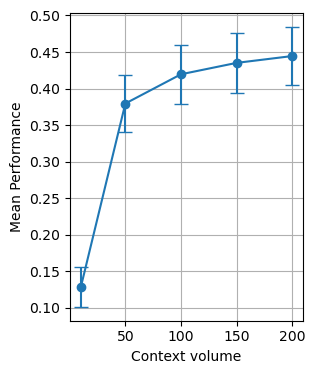

In [12]:


params = hyperparam_perf.context_volume.values
mean_performance = hyperparam_perf.performance_mean.values
std_deviation = hyperparam_perf.performance_std.values
sem_value = hyperparam_perf.performance_sem.values

fig = plt.figure(figsize=(3, 4))
plt.errorbar(params, mean_performance, yerr=sem_value, fmt='o-', capsize=5, label='Performance')
plt.xlabel('Context volume')
plt.ylabel('Mean Performance')
plt.grid(True)
# plt.ylim(0.3,0.8)
plt.show()

figure_folder_name = "hyperparam_tuning"
fig_filename = "../../../data/analysis_results/figures/{}/context_volume_two_hop.svg".format(figure_folder_name)
fig.savefig(fig_filename, format='svg', bbox_inches='tight')

